In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import copy

In [62]:
SEED=548
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import sklearn
sklearn.utils.check_random_state(SEED)
#-----------------------------------------
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()

dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph
print(data)
adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

features = torch.tensor(data.x)
# finding feature similarity across all the nodes via dot product
similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
similarities = similarities * (torch.eye(len(similarities)) == 0).long()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_25828/1516843027.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


In [63]:
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)

In [64]:
maxi=similarities.max()
# for i in range(similarities.shape[0]):
#     for j in range(similarities.shape[1]):
#         if similarities[i][j]>maxi:
#             maxi=similarities[i][j]
print(f"maximum cross similarity:{maxi}")

# normalizing similarty to lie in range [0,1]
similarities=torch.div(similarities, maxi)

alpha = 0.3
print(f"alpha:{alpha}")
max_similarities = (similarities > alpha).long()

new_edges = torch.nonzero(max_similarities, as_tuple=False).T
print(len(new_edges[1]))
existing_edges = set(map(tuple, data.edge_index.T.tolist()))

# check if there is a common edges between the ones we found and existing ones
filtered_new_edges = []
for i, j in new_edges.T.tolist():
    if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
        filtered_new_edges.append([i, j])

# print(filtered_new_edges)

prev_edges = copy.deepcopy(data.edge_index)
prev_edge_weights = copy.deepcopy(data.edge_weight)
if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

    # Append new edges to data.edge_index

    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
new_edges = data.edge_index
new_edge_weights = data.edge_weight
print(f"previous_edges:{len(prev_edges[0])}")
print(f"new_edges:{len(new_edges[0])}")


maximum cross similarity:25.0
alpha:0.3
1650
Total new edges added: 1168
previous_edges:10556
new_edges:11724


In [65]:
prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weights], dim=0)
print(prev_edges_and_weights.shape)
new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)
print(new_edges_and_weights.shape)

torch.Size([3, 10556])
torch.Size([3, 11724])


In [7]:
# save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
save_edges = lambda args: pd.DataFrame(args[0].T, columns=['col1', 'col2', 'col3']).astype(
    {'col1': int, 'col2': int, 'col3': float}
).to_csv(args[1], index=None, header=None, sep=' ', mode='a', float_format='%.1f')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    open(edges_name,'w').close()
    save_edges((edges, edges_name))

    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    else:
        open('hierarchy.txt','w').close()
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    else:
        open('vectors.txt','w').close()
    
    # do hierarchical clustering using Louvain algorithm
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    
    # obtain node embedding of each node at every hierarchy
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your output node embeddings text file
    file_path = 'vectors.txt'

    data_ = np.loadtxt(file_path)
    data_tensor = torch.from_numpy(data_)
    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)
    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    return node_ids, embeddings

In [8]:
def evaluate_node_classification(aa_node_ids, aa_embeddings, data):
    """
    Evaluates multi-class node classification using Logistic Regression.

    Args:
        aa_node_ids: List of node IDs.
        aa_embeddings: Corresponding node embeddings.
        data: PyTorch Geometric data object containing labels and masks.

    Returns:
        Micro-F1 and Macro-F1 scores.
    """

    # Map node IDs to indices in embeddings
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(aa_node_ids)}

    # Reorder embeddings to match the label ordering
    ordered_embeddings = np.zeros((len(data.y), aa_embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = aa_embeddings[node_to_idx[i]]

    # Convert masks to NumPy arrays
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()

    # Prepare train and test data
    X_train, X_test = ordered_embeddings[train_mask], ordered_embeddings[test_mask]
    y_train, y_test = data.y[train_mask].numpy(), data.y[test_mask].numpy()

    # Train Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }


In [69]:
print('Only Initial Edges:')


a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
    # print(aa_node_ids.shape)
    # print(aa_embeddings.shape)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Micro-F1: 0.6896 ± 0.0103
Macro-F1: 0.6836 ± 0.0095
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

Micro-F1: 0.7389 ± 0.0050
Macro-F1: 0.7392 ± 0.0032


after making changes to recpart.c, run this command

gcc -o recpart recpart.c partition.c -lm -O2

In [11]:
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()

def evalator(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi=similarities.max()

# normalizing similarty to lie in range [0,1]
    similarities=torch.div(similarities, maxi)
    
    max_similarities = (similarities > alpha).long()
    
    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    # check if there is a common edges between the ones we found and existing ones
    filtered_new_edges = []
    for i, j in new_edges.T.tolist():
        if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
            filtered_new_edges.append([i, j])

    # print(filtered_new_edges)

    prev_edges = copy.deepcopy(data.edge_index)
    prev_edge_weights = copy.deepcopy(data.edge_weight)
    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

        # Append new edges to data.edge_index

        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

    # print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    new_edges = data.edge_index
    new_edge_weights = data.edge_weight

    prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weights], dim=0)

    new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)

    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [14]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro new
y3=[] #macro new
y4=[]# micro
y5=[] # macro
for alpha in range(0,10):
    print("---------------------------------------------")
    alpha=alpha/10
    print("alpha:",alpha)
    xx,y1a,y2b,y3c,y4d,y5e=evalator(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b) # new  micro
    y3.append(y3c) # new  macro
    y4.append(y4d) # old  micro
    y5.append(y5e) # old  macro

---------------------------------------------
alpha: 0.0
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)
100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Micro-F1: 0.6807 ± 0.0094
Macro-F1: 0.6769 ± 0.0085
Combined Edges:


100%|██████████| 16/16 [01:18<00:00,  4.94s/it]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.3260 ± 0.0000
Macro-F1: 0.2301 ± 0.0000
---------------------------------------------
alpha: 0.1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Micro-F1: 0.6834 ± 0.0060
Macro-F1: 0.6802 ± 0.0047
Combined Edges:


100%|██████████| 16/16 [00:18<00:00,  1.14s/it]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.4630 ± 0.0000
Macro-F1: 0.3059 ± 0.0000
---------------------------------------------
alpha: 0.2
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Micro-F1: 0.6804 ± 0.0090
Macro-F1: 0.6780 ± 0.0082
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6604 ± 0.0073
Macro-F1: 0.6370 ± 0.0049
---------------------------------------------
alpha: 0.3
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


Micro-F1: 0.6891 ± 0.0107
Macro-F1: 0.6817 ± 0.0091
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7425 ± 0.0098
Macro-F1: 0.7394 ± 0.0077
---------------------------------------------
alpha: 0.4
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.03it/s]


Micro-F1: 0.6808 ± 0.0063
Macro-F1: 0.6787 ± 0.0046
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.94it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6759 ± 0.0113
Macro-F1: 0.6677 ± 0.0132
---------------------------------------------
alpha: 0.5
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.01it/s]


Micro-F1: 0.6817 ± 0.0029
Macro-F1: 0.6796 ± 0.0019
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.92it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6697 ± 0.0073
Macro-F1: 0.6696 ± 0.0048
---------------------------------------------
alpha: 0.6
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  4.84it/s]


Micro-F1: 0.6840 ± 0.0058
Macro-F1: 0.6784 ± 0.0049
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6774 ± 0.0097
Macro-F1: 0.6767 ± 0.0097
---------------------------------------------
alpha: 0.7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  4.87it/s]


Micro-F1: 0.6834 ± 0.0033
Macro-F1: 0.6801 ± 0.0033
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6897 ± 0.0152
Macro-F1: 0.6900 ± 0.0120
---------------------------------------------
alpha: 0.8
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Micro-F1: 0.6780 ± 0.0049
Macro-F1: 0.6781 ± 0.0047
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.63it/s]
/tmp/ipykernel_230440/23095297.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6854 ± 0.0078
Macro-F1: 0.6787 ± 0.0066
---------------------------------------------
alpha: 0.9
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  4.92it/s]


Micro-F1: 0.6804 ± 0.0072
Macro-F1: 0.6749 ± 0.0082
Combined Edges:


100%|██████████| 16/16 [00:05<00:00,  3.19it/s]

Micro-F1: 0.6866 ± 0.0067
Macro-F1: 0.6804 ± 0.0083


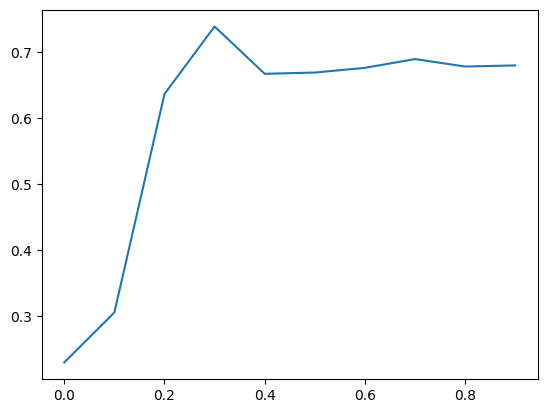

In [15]:
import matplotlib.pyplot as plt

plt.plot(x,y3)


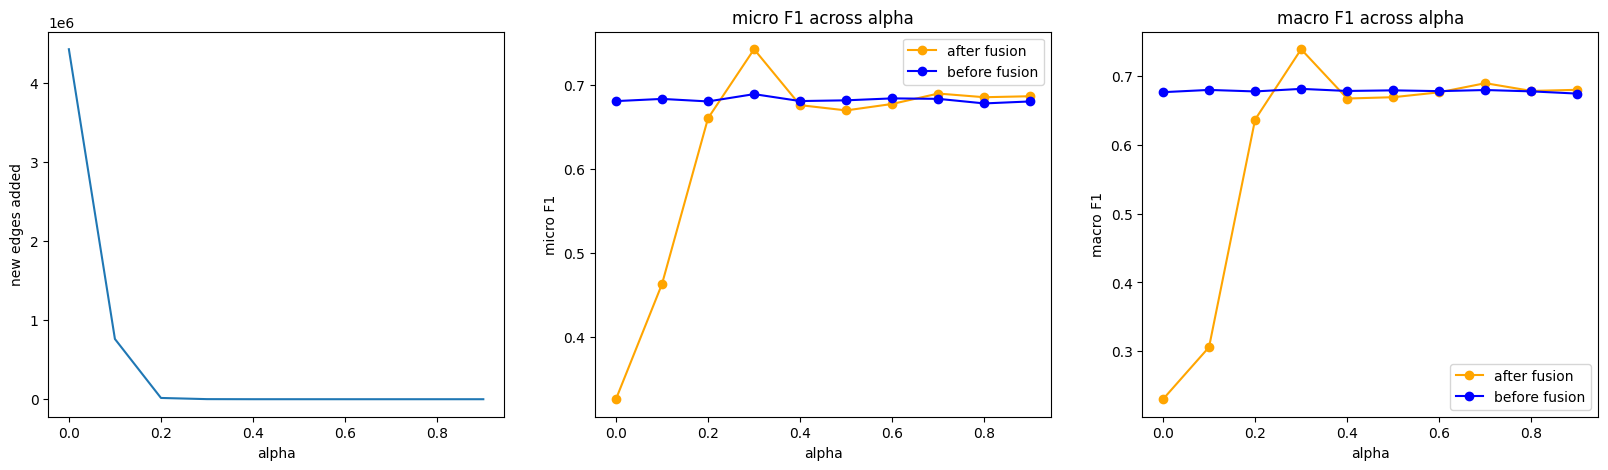

In [16]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y3,label="after fusion",marker="o",color="orange")
plt.plot(x,y5,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('macro F1')
plt.title('macro F1 across alpha')
plt.legend()

plt.show()



# Method:2
- give weight 1 to all the existing edges
- find the new edges with similarity above some threshold
- scale the new edges similarity between 0 to 1
- include the new edges to the structural graph with edge weights acc to the scaled similarities
- the edges present in both exiting edges andnew edges will have weight more than 1

In [74]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import copy

In [75]:
SEED=548
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import sklearn
sklearn.utils.check_random_state(SEED)
#-----------------------------------------
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()

dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph
print(data)
adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

features = torch.tensor(data.x)
# finding feature similarity across all the nodes via dot product
similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
similarities = similarities * (torch.eye(len(similarities)) == 0).long()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_25828/1516843027.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


In [76]:
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)

In [77]:
maxi = similarities.max()
print(f"maximum cross similarity:{maxi}")

# normalizing similarity to lie in range [0,1]
similarities = torch.div(similarities, maxi)

alpha = 0.2
print(f"alpha:{alpha}")

max_similarities = (similarities > alpha).long()

prev_edges = data.edge_index
prev_edge_weightsss = copy.deepcopy(data.edge_weight)
prev_edge_weights = copy.deepcopy(data.edge_weight)  # Create a copy to preserve original weights

new_edges = torch.nonzero(max_similarities, as_tuple=False).T

new_edges_similarities = []
for i in range(new_edges.shape[1]):
    new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
max_sim = max(new_edges_similarities)
scaled_new_similarities = [i/max_sim for i in new_edges_similarities]
# print(scaled_new_similarities)
existing_edges = set(map(tuple, data.edge_index.T.tolist()))

common_edges = []
common_idxs = []
filtered_new_edges = []
filtered_edges_sim = []

# Store mapping of common edges to their similarity values
common_edge_to_sim = {}

for idx, edge in enumerate(new_edges.T.tolist()):
    edge_tuple = (edge[0], edge[1])
    if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:
        filtered_new_edges.append([edge[0], edge[1]])
        filtered_edges_sim.append(scaled_new_similarities[idx])
    else:
        common_edges.append([edge[0], edge[1]])
        common_idxs.append(idx)
        common_edge_to_sim[edge_tuple] = scaled_new_similarities[idx]
f=False
comm=[]
# Update weights of common edges in prev_edge_weights
if common_edges:
    # Convert prev_edges to list of tuples for easier lookup
    prev_edges_list = prev_edges.T.tolist()
    for i, edge in enumerate(prev_edges_list):
        edge_tuple = tuple(edge)
        if edge_tuple in common_edge_to_sim:
            f=True
            # Update the weight (you can adjust how you want to increase it)
            prev_edge_weights[0, i] = prev_edge_weightsss[0, i] + torch.tensor(common_edge_to_sim[edge_tuple], dtype=torch.float32)
            # print(edge_tuple)
            # print(prev_edge_weightsss[0, i], torch.tensor(common_edge_to_sim[edge_tuple], dtype=torch.float32))
# print(comm)
if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T
    new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)
    
    # Append new edges to data.edge_index
    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
    data.edge_weight = torch.cat([prev_edge_weights, new_edges_simil], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
new_edges = data.edge_index
new_edge_weights = data.edge_weight
print(f"previous_edges:{len(prev_edges[0])}")
print(f"new_edges:{len(new_edges[0])}")

maximum cross similarity:25.0
alpha:0.2
Total new edges added: 16050
previous_edges:10556
new_edges:26606


In [78]:
prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weightsss], dim=0)
print(prev_edges_and_weights.shape)
new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)
print(new_edges_and_weights.shape)

torch.Size([3, 10556])
torch.Size([3, 26606])


In [79]:
# save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
save_edges = lambda args: pd.DataFrame(args[0].T, columns=['col1', 'col2', 'col3']).astype(
    {'col1': int, 'col2': int, 'col3': float}
).to_csv(args[1], index=None, header=None, sep=' ', mode='a', float_format='%.1f')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    open(edges_name,'w').close()
    save_edges((edges, edges_name))

    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    else:
        open('hierarchy.txt','w').close()
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    else:
        open('vectors.txt','w').close()
    
    # do hierarchical clustering using Louvain algorithm
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    
    # obtain node embedding of each node at every hierarchy
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your output node embeddings text file
    file_path = 'vectors.txt'

    data_ = np.loadtxt(file_path)
    data_tensor = torch.from_numpy(data_)
    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)
    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    return node_ids, embeddings

In [80]:
def evaluate_node_classification(aa_node_ids, aa_embeddings, data):
    """
    Evaluates multi-class node classification using Logistic Regression.

    Args:
        aa_node_ids: List of node IDs.
        aa_embeddings: Corresponding node embeddings.
        data: PyTorch Geometric data object containing labels and masks.

    Returns:
        Micro-F1 and Macro-F1 scores.
    """

    # Map node IDs to indices in embeddings
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(aa_node_ids)}

    # Reorder embeddings to match the label ordering
    ordered_embeddings = np.zeros((len(data.y), aa_embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = aa_embeddings[node_to_idx[i]]

    # Convert masks to NumPy arrays
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()

    # Prepare train and test data
    X_train, X_test = ordered_embeddings[train_mask], ordered_embeddings[test_mask]
    y_train, y_test = data.y[train_mask].numpy(), data.y[test_mask].numpy()

    # Train Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }


In [81]:
print('Only Initial Edges:')


a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
    # print(aa_node_ids.shape)
    # print(aa_embeddings.shape)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


Micro-F1: 0.6816 ± 0.0080
Macro-F1: 0.6764 ± 0.0062
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.81it/s]

Micro-F1: 0.7245 ± 0.0058
Macro-F1: 0.7262 ± 0.0037


In [17]:
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()
def evalator_m2(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi = similarities.max()
    print(f"maximum cross similarity:{maxi}")

    # normalizing similarity to lie in range [0,1]
    similarities = torch.div(similarities, maxi)

    print(f"alpha:{alpha}")

    max_similarities = (similarities > alpha).long()

    prev_edges = data.edge_index
    prev_edge_weightsss = copy.deepcopy(data.edge_weight)
    prev_edge_weights = copy.deepcopy(data.edge_weight)  # Create a copy to preserve original weights

    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    new_edges_similarities = []
    for i in range(new_edges.shape[1]):
        new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
    max_sim = max(new_edges_similarities)
    scaled_new_similarities = [i/max_sim for i in new_edges_similarities]
    # print(scaled_new_similarities)
    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    common_edges = []
    common_idxs = []
    filtered_new_edges = []
    filtered_edges_sim = []

    # Store mapping of common edges to their similarity values
    common_edge_to_sim = {}

    for idx, edge in enumerate(new_edges.T.tolist()):
        edge_tuple = (edge[0], edge[1])
        if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:
            filtered_new_edges.append([edge[0], edge[1]])
            filtered_edges_sim.append(scaled_new_similarities[idx])
        else:
            common_edges.append([edge[0], edge[1]])
            common_idxs.append(idx)
            common_edge_to_sim[edge_tuple] = scaled_new_similarities[idx]
    f=False
    comm=[]
    # Update weights of common edges in prev_edge_weights
    if common_edges:
        # Convert prev_edges to list of tuples for easier lookup
        prev_edges_list = prev_edges.T.tolist()
        for i, edge in enumerate(prev_edges_list):
            edge_tuple = tuple(edge)
            if edge_tuple in common_edge_to_sim:
                f=True
                # Update the weight (you can adjust how you want to increase it)
                prev_edge_weights[0, i] = prev_edge_weightsss[0, i] + torch.tensor(common_edge_to_sim[edge_tuple], dtype=torch.float32)

    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T
        new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)
        
        # Append new edges to data.edge_index
        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
        data.edge_weight = torch.cat([prev_edge_weights, new_edges_simil], dim=1)

    print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
    new_edges = data.edge_index
    new_edge_weights = data.edge_weight

    prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weightsss], dim=0)
    new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)

    print('Only Initial Edges:')
    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [18]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro
y3=[] #macro
y4=[]# micro
y5=[] # marcro
for alpha in range(0,10):
    print("---------------------------------------------")
    alpha=alpha/10
    print("alpha:",alpha)
    xx,y1a,y2b,y3c,y4d,y5e=evalator_m2(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b)
    y3.append(y3c)
    y4.append(y4d)
    y5.append(y5e)

---------------------------------------------
alpha: 0.0
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.0


/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Total new edges added: 4428556
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Micro-F1: 0.6806 ± 0.0036
Macro-F1: 0.6768 ± 0.0046
Combined Edges:


100%|██████████| 16/16 [01:27<00:00,  5.44s/it]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.4938 ± 0.0010
Macro-F1: 0.3869 ± 0.0011
---------------------------------------------
alpha: 0.1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.1
Total new edges added: 762060
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Micro-F1: 0.6942 ± 0.0107
Macro-F1: 0.6885 ± 0.0072
Combined Edges:


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6663 ± 0.0016
Macro-F1: 0.6395 ± 0.0008
---------------------------------------------
alpha: 0.2
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.2
Total new edges added: 16050
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]


Micro-F1: 0.6784 ± 0.0052
Macro-F1: 0.6726 ± 0.0042
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.58it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7241 ± 0.0071
Macro-F1: 0.7238 ± 0.0048
---------------------------------------------
alpha: 0.3
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.3
Total new edges added: 1168
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.00it/s]


Micro-F1: 0.6746 ± 0.0065
Macro-F1: 0.6707 ± 0.0068
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.12it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6871 ± 0.0129
Macro-F1: 0.6950 ± 0.0128
---------------------------------------------
alpha: 0.4
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.4
Total new edges added: 180
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.28it/s]


Micro-F1: 0.6789 ± 0.0037
Macro-F1: 0.6747 ± 0.0012
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6861 ± 0.0061
Macro-F1: 0.6760 ± 0.0062
---------------------------------------------
alpha: 0.5
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.5
Total new edges added: 126
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.13it/s]


Micro-F1: 0.6925 ± 0.0080
Macro-F1: 0.6843 ± 0.0077
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.07it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6779 ± 0.0060
Macro-F1: 0.6697 ± 0.0058
---------------------------------------------
alpha: 0.6
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.6
Total new edges added: 92
Only Initial Edges:


100%|██████████| 16/16 [00:04<00:00,  3.23it/s]


Micro-F1: 0.6759 ± 0.0075
Macro-F1: 0.6743 ± 0.0052
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.78it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6939 ± 0.0149
Macro-F1: 0.6853 ± 0.0153
---------------------------------------------
alpha: 0.7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.7
Total new edges added: 74
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.88it/s]


Micro-F1: 0.6897 ± 0.0064
Macro-F1: 0.6836 ± 0.0060
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.87it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6872 ± 0.0087
Macro-F1: 0.6795 ± 0.0077
---------------------------------------------
alpha: 0.8
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.8
Total new edges added: 34
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.87it/s]


Micro-F1: 0.6934 ± 0.0089
Macro-F1: 0.6871 ± 0.0049
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.72it/s]
/tmp/ipykernel_230440/161969321.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6904 ± 0.0068
Macro-F1: 0.6808 ± 0.0039
---------------------------------------------
alpha: 0.9
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.9
Total new edges added: 22
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.98it/s]


Micro-F1: 0.6900 ± 0.0108
Macro-F1: 0.6848 ± 0.0086
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

Micro-F1: 0.6831 ± 0.0041
Macro-F1: 0.6782 ± 0.0039


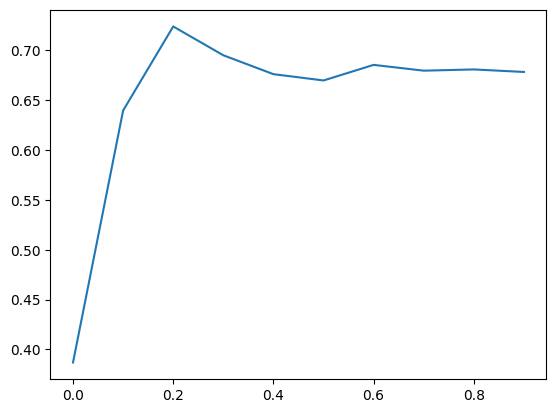

In [19]:
import matplotlib.pyplot as plt

plt.plot(x,y3)


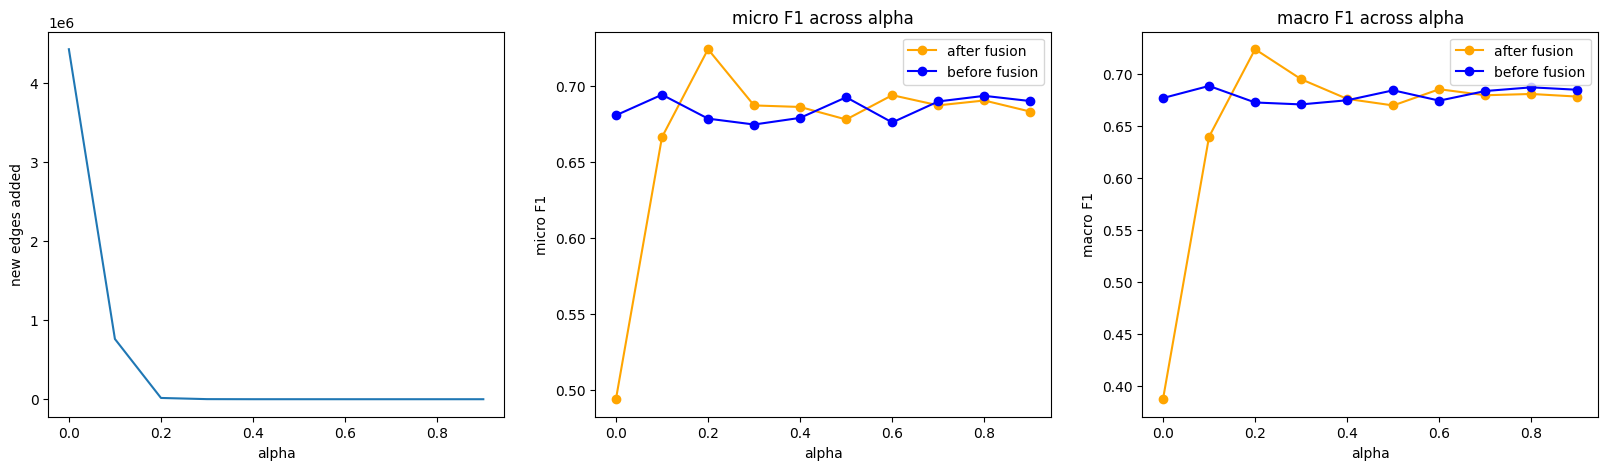

In [20]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y3,label="after fusion",marker="o",color="orange")
plt.plot(x,y5,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('macro F1')
plt.title('macro F1 across alpha')
plt.legend()

plt.show()



# Method: 3
- give weight 1 to all the existing edges
- find the new edges with similarity above some threshold
- scale the new edges similarity between 0 to 1
- include the new edges to the structural graph with edge weights as 1
- the edges present in both exiting edges andnew edges will have weight more than 1

In [21]:
def evalator_m3(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi = similarities.max()
    print(f"maximum cross similarity:{maxi}")

    # normalizing similarity to lie in range [0,1]
    similarities = torch.div(similarities, maxi)

    print(f"alpha:{alpha}")

    max_similarities = (similarities > alpha).long()

    prev_edges = data.edge_index
    prev_edge_weightsss = copy.deepcopy(data.edge_weight)
    prev_edge_weights = copy.deepcopy(data.edge_weight)  # Create a copy to preserve original weights

    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    new_edges_similarities = []
    for i in range(new_edges.shape[1]):
        new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
    max_sim = max(new_edges_similarities)
    scaled_new_similarities = [i/max_sim for i in new_edges_similarities]
    # print(scaled_new_similarities)
    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    common_edges = []
    common_idxs = []
    filtered_new_edges = []
    filtered_edges_sim = []

    # Store mapping of common edges to their similarity values
    common_edge_to_sim = {}

    for idx, edge in enumerate(new_edges.T.tolist()):
        edge_tuple = (edge[0], edge[1])
        if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:
            filtered_new_edges.append([edge[0], edge[1]])
            # filtered_edges_sim.append(scaled_new_similarities[idx])
            filtered_edges_sim.append(1)
        else:
            common_edges.append([edge[0], edge[1]])
            common_idxs.append(idx)
            common_edge_to_sim[edge_tuple] = scaled_new_similarities[idx]
    f=False
    comm=[]
    # Update weights of common edges in prev_edge_weights
    if common_edges:
        # Convert prev_edges to list of tuples for easier lookup
        prev_edges_list = prev_edges.T.tolist()
        for i, edge in enumerate(prev_edges_list):
            edge_tuple = tuple(edge)
            if edge_tuple in common_edge_to_sim:
                f=True
                # Update the weight (you can adjust how you want to increase it)
                prev_edge_weights[0, i] = prev_edge_weightsss[0, i] + torch.tensor(common_edge_to_sim[edge_tuple], dtype=torch.float32)

    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T
        new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)
        
        # Append new edges to data.edge_index
        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
        data.edge_weight = torch.cat([prev_edge_weights, new_edges_simil], dim=1)

    print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
    new_edges = data.edge_index
    new_edge_weights = data.edge_weight

    prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weightsss], dim=0)
    new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)

    print('Only Initial Edges:')
    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [89]:
evalator_m3(0.25)

/tmp/ipykernel_25828/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.25
Total new edges added: 4122
Only Initial Edges:


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Micro-F1: 0.6794 ± 0.0087
Macro-F1: 0.6736 ± 0.0092
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.00it/s]

Micro-F1: 0.7130 ± 0.0072
Macro-F1: 0.6967 ± 0.0058


(0.25, 4122, 0.713, 0.6966839669109541, 0.6793750000000001, 0.6735824957199146)

In [22]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro
y3=[] #macro
y4=[]# micro
y5=[] # marcro
for alpha in range(0,10):
    print("---------------------------------------------")
    alpha=alpha/10
    print("alpha:",alpha)
    xx,y1a,y2b,y3c,y4d,y5e=evalator_m3(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b)
    y3.append(y3c)
    y4.append(y4d)
    y5.append(y5e)

---------------------------------------------
alpha: 0.0
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.0


/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Total new edges added: 4428556
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Micro-F1: 0.6774 ± 0.0019
Macro-F1: 0.6752 ± 0.0036
Combined Edges:


100%|██████████| 16/16 [01:22<00:00,  5.15s/it]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.2770 ± 0.0000
Macro-F1: 0.2182 ± 0.0000
---------------------------------------------
alpha: 0.1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.1
Total new edges added: 762060
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.01it/s]


Micro-F1: 0.6849 ± 0.0055
Macro-F1: 0.6815 ± 0.0053
Combined Edges:


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.5390 ± 0.0000
Macro-F1: 0.4152 ± 0.0000
---------------------------------------------
alpha: 0.2
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.2
Total new edges added: 16050
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Micro-F1: 0.6843 ± 0.0031
Macro-F1: 0.6783 ± 0.0028
Combined Edges:


100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7102 ± 0.0059
Macro-F1: 0.6879 ± 0.0036
---------------------------------------------
alpha: 0.3
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.3
Total new edges added: 1168
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


Micro-F1: 0.6730 ± 0.0074
Macro-F1: 0.6718 ± 0.0061
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.90it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6711 ± 0.0014
Macro-F1: 0.6803 ± 0.0012
---------------------------------------------
alpha: 0.4
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.4
Total new edges added: 180
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Micro-F1: 0.6829 ± 0.0103
Macro-F1: 0.6788 ± 0.0062
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6779 ± 0.0095
Macro-F1: 0.6734 ± 0.0056
---------------------------------------------
alpha: 0.5
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.5
Total new edges added: 126
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Micro-F1: 0.6863 ± 0.0096
Macro-F1: 0.6819 ± 0.0081
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6804 ± 0.0116
Macro-F1: 0.6763 ± 0.0085
---------------------------------------------
alpha: 0.6
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.6
Total new edges added: 92
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.71it/s]


Micro-F1: 0.6829 ± 0.0041
Macro-F1: 0.6802 ± 0.0022
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.70it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6866 ± 0.0133
Macro-F1: 0.6811 ± 0.0115
---------------------------------------------
alpha: 0.7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.7
Total new edges added: 74
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.67it/s]


Micro-F1: 0.6814 ± 0.0023
Macro-F1: 0.6780 ± 0.0022
Combined Edges:


100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6859 ± 0.0141
Macro-F1: 0.6786 ± 0.0118
---------------------------------------------
alpha: 0.8
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.8
Total new edges added: 34
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.80it/s]


Micro-F1: 0.6967 ± 0.0079
Macro-F1: 0.6894 ± 0.0068
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.65it/s]
/tmp/ipykernel_230440/532984493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6861 ± 0.0080
Macro-F1: 0.6771 ± 0.0074
---------------------------------------------
alpha: 0.9
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.9
Total new edges added: 22
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.77it/s]


Micro-F1: 0.6826 ± 0.0077
Macro-F1: 0.6806 ± 0.0048
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

Micro-F1: 0.6893 ± 0.0134
Macro-F1: 0.6809 ± 0.0100


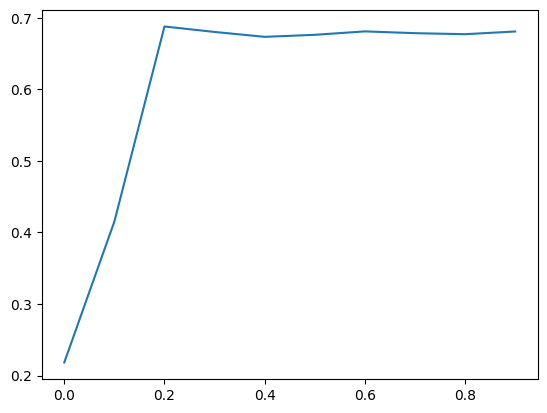

In [23]:
import matplotlib.pyplot as plt

plt.plot(x,y3)

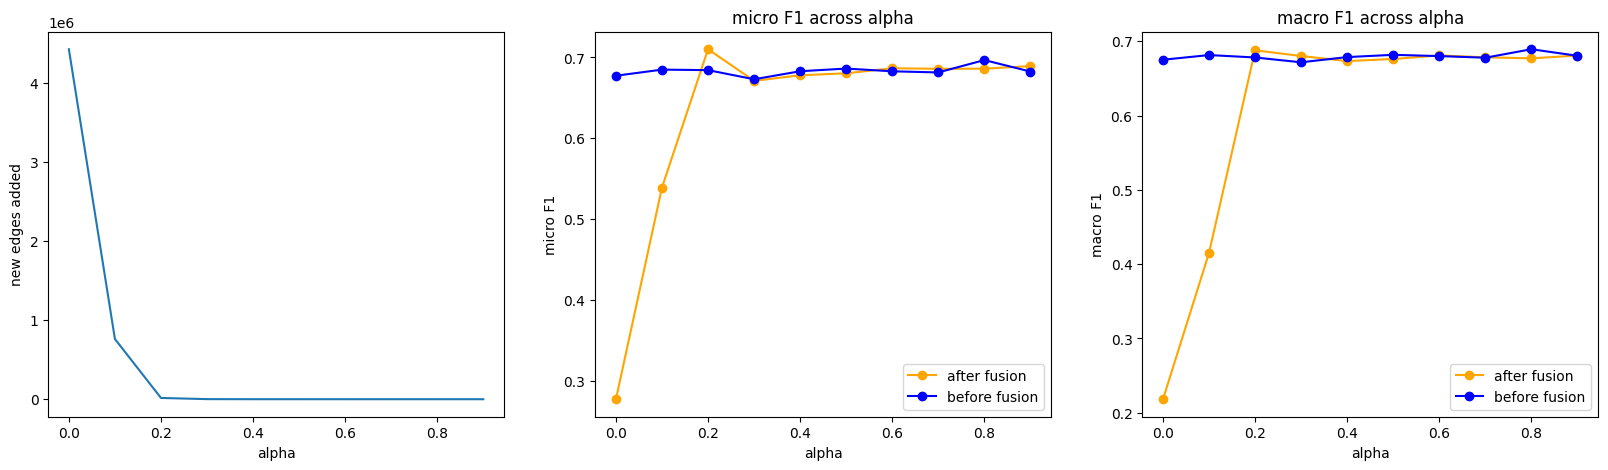

In [24]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y3,label="after fusion",marker="o",color="orange")
plt.plot(x,y5,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('macro F1')
plt.title('macro F1 across alpha')
plt.legend()

plt.show()

# Method:4

In [25]:
def evalator_m4(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi = similarities.max()
    print(f"maximum cross similarity:{maxi}")

    # normalizing similarity to lie in range [0,1]
    similarities = torch.div(similarities, maxi)

    print(f"alpha:{alpha}")

    max_similarities = (similarities > alpha).long()

    prev_edges = data.edge_index
    prev_edge_weightsss = copy.deepcopy(data.edge_weight)
    prev_edge_weights = copy.deepcopy(data.edge_weight)  # Create a copy to preserve original weights

    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    new_edges_similarities = []
    for i in range(new_edges.shape[1]):
        new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
    max_sim = max(new_edges_similarities)
    scaled_new_similarities = [i/max_sim for i in new_edges_similarities]
    # print(scaled_new_similarities)
    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    common_edges = []
    common_idxs = []
    filtered_new_edges = []
    filtered_edges_sim = []

    # Store mapping of common edges to their similarity values
    common_edge_to_sim = {}

    for idx, edge in enumerate(new_edges.T.tolist()):
        edge_tuple = (edge[0], edge[1])
        if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:
            filtered_new_edges.append([edge[0], edge[1]])
            # filtered_edges_sim.append(scaled_new_similarities[idx])
            filtered_edges_sim.append(1)
        else:
            common_edges.append([edge[0], edge[1]])
            common_idxs.append(idx)
            common_edge_to_sim[edge_tuple] = scaled_new_similarities[idx]
    f=False
    comm=[]
    # Update weights of common edges in prev_edge_weights
    if common_edges:
        # Convert prev_edges to list of tuples for easier lookup
        prev_edges_list = prev_edges.T.tolist()
        for i, edge in enumerate(prev_edges_list):
            edge_tuple = tuple(edge)
            if edge_tuple in common_edge_to_sim:
                f=True
                # Update the weight (you can adjust how you want to increase it)
                prev_edge_weights[0, i] = prev_edge_weightsss[0, i] + 1

    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T
        new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)
        
        # Append new edges to data.edge_index
        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
        data.edge_weight = torch.cat([prev_edge_weights, new_edges_simil], dim=1)

    print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
    new_edges = data.edge_index
    new_edge_weights = data.edge_weight

    prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weightsss], dim=0)
    new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)

    print('Only Initial Edges:')
    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [26]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro
y3=[] #macro
y4=[]# micro
y5=[] # marcro
for alpha in range(0,10):
    print("---------------------------------------------")
    alpha=alpha/10
    print("alpha:",alpha)
    xx,y1a,y2b,y3c,y4d,y5e=evalator_m4(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b)
    y3.append(y3c)
    y4.append(y4d)
    y5.append(y5e)

---------------------------------------------
alpha: 0.0
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.0


/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Total new edges added: 4428556
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Micro-F1: 0.6928 ± 0.0132
Macro-F1: 0.6831 ± 0.0107
Combined Edges:


100%|██████████| 16/16 [01:20<00:00,  5.06s/it]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.3013 ± 0.0029
Macro-F1: 0.2006 ± 0.0064
---------------------------------------------
alpha: 0.1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.1
Total new edges added: 762060
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.94it/s]


Micro-F1: 0.6848 ± 0.0117
Macro-F1: 0.6794 ± 0.0093
Combined Edges:


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.5400 ± 0.0000
Macro-F1: 0.4131 ± 0.0000
---------------------------------------------
alpha: 0.2
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.2
Total new edges added: 16050
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


Micro-F1: 0.6795 ± 0.0090
Macro-F1: 0.6756 ± 0.0091
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.62it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6754 ± 0.0112
Macro-F1: 0.6663 ± 0.0067
---------------------------------------------
alpha: 0.3
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.3
Total new edges added: 1168
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


Micro-F1: 0.6777 ± 0.0056
Macro-F1: 0.6731 ± 0.0056
Combined Edges:


100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7012 ± 0.0078
Macro-F1: 0.6913 ± 0.0073
---------------------------------------------
alpha: 0.4
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.4
Total new edges added: 180
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


Micro-F1: 0.6775 ± 0.0110
Macro-F1: 0.6738 ± 0.0102
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.94it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6870 ± 0.0132
Macro-F1: 0.6821 ± 0.0071
---------------------------------------------
alpha: 0.5
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.5
Total new edges added: 126
Only Initial Edges:


100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


Micro-F1: 0.6848 ± 0.0085
Macro-F1: 0.6787 ± 0.0059
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6924 ± 0.0100
Macro-F1: 0.6768 ± 0.0085
---------------------------------------------
alpha: 0.6
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.6
Total new edges added: 92
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Micro-F1: 0.6947 ± 0.0067
Macro-F1: 0.6862 ± 0.0062
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.97it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6834 ± 0.0074
Macro-F1: 0.6751 ± 0.0042
---------------------------------------------
alpha: 0.7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.7
Total new edges added: 74
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


Micro-F1: 0.6823 ± 0.0064
Macro-F1: 0.6797 ± 0.0083
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.88it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6823 ± 0.0053
Macro-F1: 0.6783 ± 0.0057
---------------------------------------------
alpha: 0.8
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.8
Total new edges added: 34
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.88it/s]


Micro-F1: 0.6895 ± 0.0089
Macro-F1: 0.6859 ± 0.0076
Combined Edges:


100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
/tmp/ipykernel_230440/975449030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6881 ± 0.0055
Macro-F1: 0.6792 ± 0.0049
---------------------------------------------
alpha: 0.9
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.9
Total new edges added: 22
Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


Micro-F1: 0.6886 ± 0.0079
Macro-F1: 0.6820 ± 0.0051
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.84it/s]

Micro-F1: 0.6996 ± 0.0131
Macro-F1: 0.6900 ± 0.0110


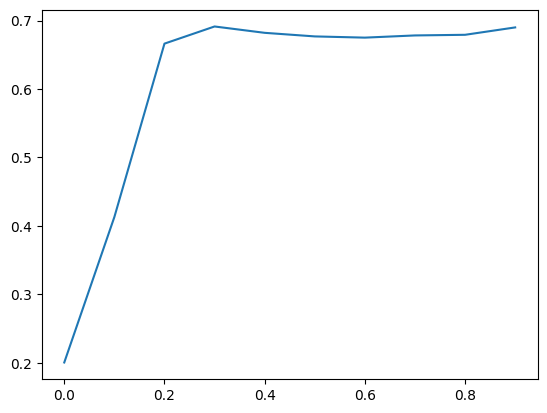

In [27]:
import matplotlib.pyplot as plt

plt.plot(x,y3)

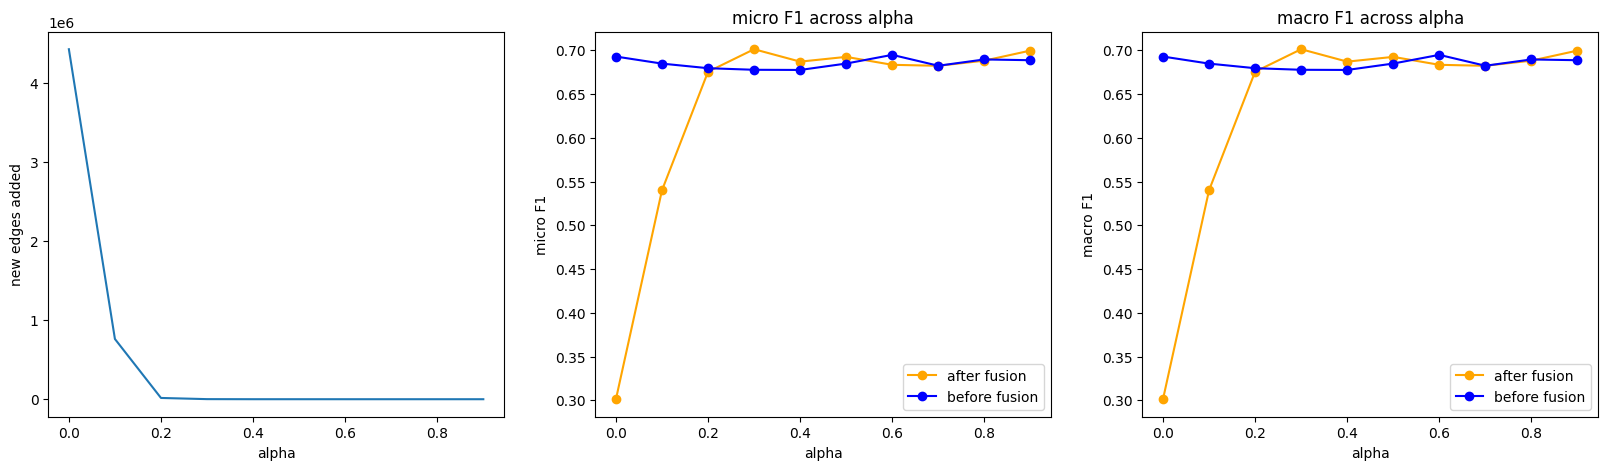

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('macro F1')
plt.title('macro F1 across alpha')
plt.legend()

plt.show()